# Ćwiczenie 3 - Triangulacja wielokątów monotonicznych

## Konfiguracja środowiska graficznego

In [158]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

## Interfejsy

In [159]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


### Funkcja wyznaczająca wyznacznik dla 3 punktów

In [160]:
eps = 10**(-12)

# <0 -> p3 po prawej

def det(p1, p2, p3):
    d = (p2[0] - p1[0])*(p3[1] - p1[1]) - (p2[1] - p1[1])*(p3[0] - p1[0])
    if abs(d)<eps:
        return 0
    else: 
        return d

### Funkcje klasyfikujące punkty 

In [161]:
# p - indeks w L pod którym znajduje się badany wierzchołek
def poczatkowy(a,b,c):
    if a[1]<b[1] and c[1]<b[1] and det(a,b,c)<0:
        return True
    return False


def koncowy(a,b,c):
    if a[1]>b[1] and c[1]>b[1] and det(a,b,c)<0:
        return True
    return False
    
    
def laczacy(a,b,c):
    if a[1]>b[1] and c[1]>b[1] and det(a,b,c)>0:
        return True
    return False    

def dzielacy(a,b,c):
    if a[1]<b[1] and c[1]<b[1] and det(a,b,c)>0:
        return True
    return False


# wierzchołek prawidłowy w pozostałych przypadkach


### Funkcja sprawdzająca czy podany wierzchołek jest y-monotoniczny

In [162]:
def Y_monotinic(points):
    # sprawdzam czy nie ma wierzchołków dzielących i łączących - jeśli ma to nie jest y-monotoniczny
    
    n = len(points)
    for i in range(1,n-1):
        if dzielacy(points[i+1], points[i], points[i-1]):
            return False
        elif laczacy(points[i+1], points[i], points[i-1]):
            return False
        
    # pierwszy
    if dzielacy(points[1], points[0], points[n-1]):
        return False
    elif laczacy(points[1], points[0], points[n-1]):
        return False
    
    
    # ostatni
    if dzielacy(points[0], points[n-1], points[n-2]):
        return False
    elif laczacy(points[0], points[n-1], points[n-2]):
        return False
    
    return True
    
    

### Funkcja dokonująca klasyfikacji punktów, wizualizacja ich na wykresie

In [163]:
# green -> początkowe
# red -> końcowe
# blue -> łączące
# violet -> dzielące
# yellow -> prawidłowe

def classify(L, lines):
    pocz = []
    konc = []
    lacz = []
    dzel = []
    praw = []
    
    n= len(L)
    
    for i in range(1,len(L)-1):
        if poczatkowy(L[i+1],L[i],L[i-1]):
            pocz.append(L[i])
        elif koncowy(L[i+1],L[i],L[i-1]):
            konc.append(L[i])
        elif laczacy(L[i+1],L[i],L[i-1]):
            lacz.append(L[i])
        elif dzielacy(L[i+1],L[i],L[i-1]):
            dzel.append(L[i])
        else:
            praw.append(L[i])
            
    
    
    ### dla pierwszego wierzchołka
    
    if poczatkowy(L[1],L[0],L[n-1]):
        pocz.append(L[0])
    elif koncowy(L[1],L[0],L[n-1]):
        konc.append(L[0])
    elif laczacy(L[1],L[0],L[n-1]):
        lacz.append(L[0])
    elif dzielacy(L[1],L[0],L[n-1]):
        dzel.append(L[0])
    else:
        praw.append(L[0])
    
    
    ### dla ostatniego wierzchołka
    
    
    if poczatkowy(L[0],L[n-1],L[n-2]):
        pocz.append(L[n-1])
    elif koncowy(L[0],L[n-1],L[n-2]):
        konc.append(L[n-1])
    elif laczacy(L[0],L[n-1],L[n-2]):
        lacz.append(L[n-1])
    elif dzielacy(L[0],L[n-1],L[n-2]):
        dzel.append(L[n-1])
    else:
        praw.append(L[n-1])
    
    
            
    scene = [Scene([PointsCollection(pocz, color='green'), PointsCollection(konc, color='red'), 
                   PointsCollection(lacz, color='blue'), PointsCollection(dzel, color='violet'), 
                  PointsCollection(praw, color='orange')], [LinesCollection(lines, color='black')])]
    
    plot = Plot(scene)
    plot.draw()
    
    

### Funkcje konwertujące zadane figury i linie

In [164]:
# potrzebna do konwersji figury zadanej przez rysowanie
def figure_to_lines(figure):
    res = []
    for i in figure:
        res+=i.lines
    return res

def lines_to_points(lines):
    res = []
    for i in range(len(lines)):
        res.append(lines[i][0])
    
    return res

### Funkcje znajdujące punkt początkowy i końcowy

In [165]:
# jeśli jest y-monotoniczny to mam tylko jeden początkowy i 1 końcowy wierzchołek

def find_start(points):
    n = len(points)
    for i in range(1,n-1):
        if poczatkowy(points[i+1], points[i], points[i-1]):
            return i
    
    if poczatkowy(points[1],points[0],points[n-1]):
        return 0
    
    if poczatkowy(points[0],points[n-1],points[n-2]):
        return n-1
    

def find_end(points):
    n = len(points)
    for i in range(1,n-1):
        if koncowy(points[i+1], points[i], points[i-1]):
            return i
    
    if koncowy(points[1],points[0],points[n-1]):
        return 0
    
    if koncowy(points[0],points[n-1],points[n-2]):
        return n-1
    

### Funkcja dzieląca punkty na dwa łańcuchy - prawy i lewy

In [166]:
def chains(points, lines):
    left = set()
    right = set()
    
    # indeksy wierzchołków końcowych i początkowych
    start = find_start(points)
    end = find_end(points)
    
    # korzystam z faktu, że figury są zadawane przeciwnie do ruchu wskazówek zegara
    # nie sortuję punktów tylko korzystam z nich tak jak zostały dodane 
    
    n = len(points)
    i = end
    while (i+1)%n != start:
        i=(i+1)%n
        right.add(points[i])

    
    i = start
    while (i+1)%n != end:
        i=(i+1)%n
        left.add(points[i])

    return left, right
    
    


### Funkcja sprawdzająca czy dwa punkty znajdują się na tym samym łańcuchu

In [167]:
def same_chain(left, right, p1,p2):
    if p1 in left and p2 in left:
        return True
    if p1 in right and p2 in right:
        return True
    
    return False

### Funkcja sprawdzająca czy przekątna znajduje się wewnątrz wielokąta

In [168]:
def check_if_diagnonal_inside(left, a, b, c):
    # jeśli jestem na lewym łańcuchu to żeby przekątna była wewnątrz, to punkt c musi być na lewo, czyli det >0
    if c in left:
        return det(a,b,c) > 0
    return det(a,b,c) < 0
    

### Funkcja dokonująca triangulacji wielokąta monotonicznego

In [169]:
from collections import deque  # stos
 
# lines są tylko potrzebne do wizualizacji
def triangulate(points, lines):
    # najpierw sprawdzam czy jest y-monotoniczny
    if not Y_monotinic(points):
        print("podany wielokąt nie jest y-monotoniczny, przerywam pracę programu")
        return None, None
    
    scenes = []
    scenes.append(Scene([PointsCollection(points, color='green')], [LinesCollection(lines, color='black')]))
    
    # określam lewy i prawy łańcuch wielokąta względem kierunku monotoniczności
    left, right = chains(points, lines)
    
    n = len(points)
    
    # porządkuję wierzchołki wzdłuż kierunku monotoniczności - sortuję po y
    # TODO użyć merge, żeby była złożoność liniowa!!!!!!!!!!!!!!!
    points.sort(key = lambda points: (points[1],points[0]))
    
    stack = deque()
    stack.append(points[0])
    stack.append(points[1])
    
    scenes.append(Scene([PointsCollection(points, color='green')], 
                         [LinesCollection(lines, color='black')]))
    
    diagonals = []
    
    for i in range(2,n-1):
        if not same_chain(left, right, stack[-1], points[i]):
            while len(stack)>1 and not same_chain(left, right, stack[-1], points[i]):
                u = stack.pop()
                diagonals.append((points[i], u))
                d = diagonals[:]
                scenes.append(Scene([PointsCollection(points, color='green')], 
                          [LinesCollection(lines, color='black'), LinesCollection(d, color='blue')]))   
            stack.clear()
            stack.append(points[i-1])
            stack.append(points[i])
            
        else:
            u = stack.pop()
            while len(stack)>1 and check_if_diagnonal_inside(left,stack[-1],u,points[i]):
                diagonals.append((points[i],u))
                d = diagonals[:]
                scenes.append(Scene([PointsCollection(points, color='green')], 
                          [LinesCollection(lines, color='black'), LinesCollection(d, color='blue')]))
                u = stack.pop()
            
            if len(stack)==1 and check_if_diagnonal_inside(left, points[i-1], stack[0],points[i]):
                diagonals.append((points[i],stack[0]))
                d = diagonals[:]
                scenes.append(Scene([PointsCollection(points, color='green')], 
                          [LinesCollection(lines, color='black'), LinesCollection(d, color='blue')]))
                u = stack.pop()
            
        
            stack.append(u)
            stack.append(points[i])
    
    
    stack.pop()
    while len(stack)>1:
        u = stack.pop()
        diagonals.append((points[n-1],u))
        d = diagonals[:]
        scenes.append(Scene([PointsCollection(points, color='green')], 
                          [LinesCollection(lines, color='black'), LinesCollection(d, color='blue')]))
    
    return diagonals, scenes
 

# Klasyfikacja i triangulacja dla dowolnego wielokąta

### Zadaj wielokąt
W kierunku przeciwnym do ruchu wskazówek zegara

<IPython.core.display.Javascript object>


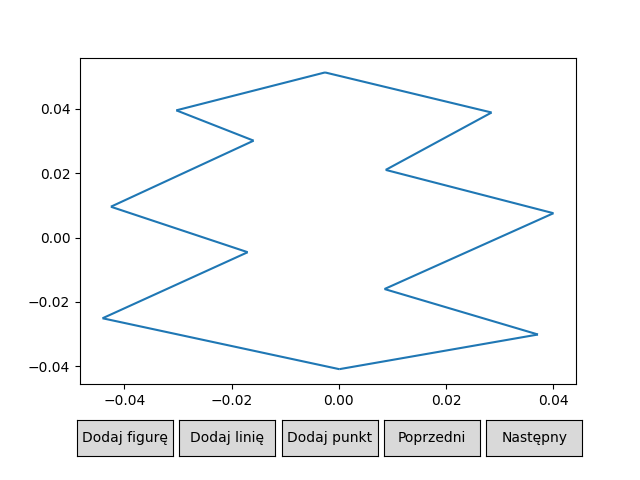

In [147]:
%matplotlib notebook

plot1 = Plot()
plot1.draw()

### Zapisz wielokąt do pliku

In [148]:
plot2 = Plot([plot1.get_added_elements()])
with open('somefile.json', 'w') as file:
    file.write(plot2.toJson())

### Wyrysuj zadany wielokąt

<IPython.core.display.Javascript object>


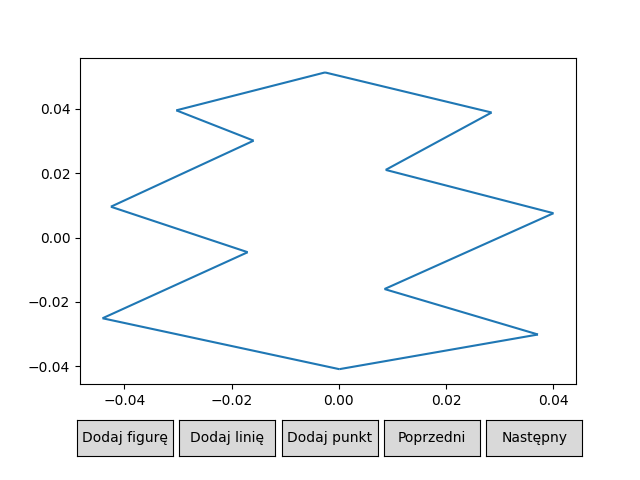

In [149]:
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

In [154]:
lines = figure_to_lines(plot1.get_added_figure())
points = lines_to_points(lines)

Jest y-monotoniczny


<IPython.core.display.Javascript object>


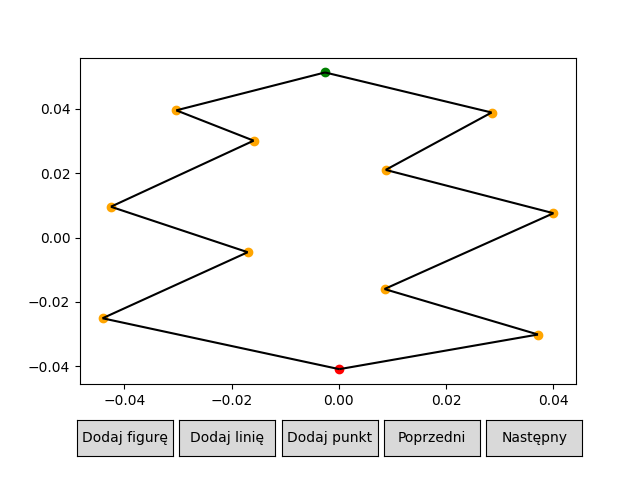

In [151]:
if Y_monotinic(points):
    print("Jest y-monotoniczny")
else:
    print("Nie jest y-monotoniczny")

classify(points, lines)

<IPython.core.display.Javascript object>


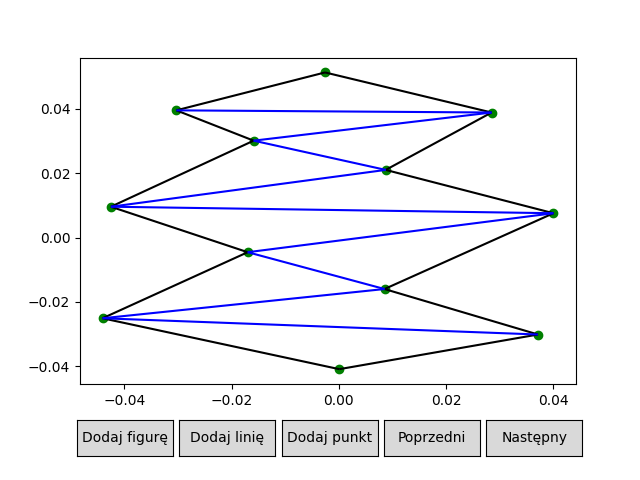

In [152]:
d,s = triangulate(points, lines)
if s:
    plot = Plot(s)
    plot.draw()

# Wielokąty sprawdzające działanie programu

## Wielokąt 1

<IPython.core.display.Javascript object>


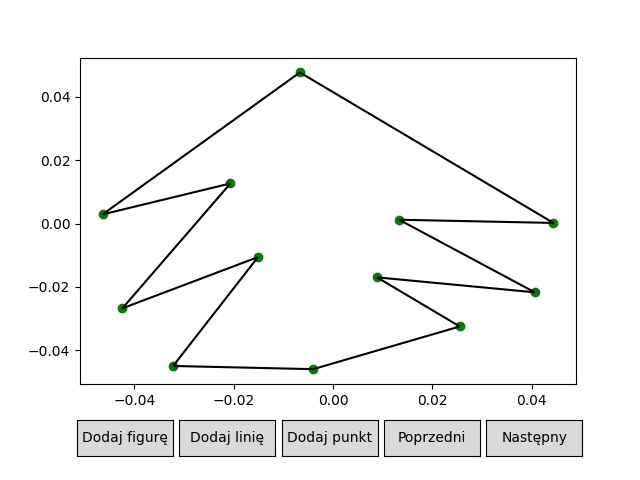

In [170]:
lines1 = [[(-0.004014114256828072, -0.045962525910022214), (0.02548185348510741, -0.03248213375315947)],
          [(0.02548185348510741, -0.03248213375315947), (0.00884878896897838, -0.016979682772767304)],
          [(0.00884878896897838, -0.016979682772767304), (0.04056249864639774, -0.021697820027669262)], 
          [(0.04056249864639774, -0.021697820027669262), (0.013284272839946126, 0.0012188466389974062)], 
          [(0.013284272839946126, 0.0012188466389974062), (0.04433265993672032, 0.0002078172272327039)], 
          [(0.04433265993672032, 0.0002078172272327039), (-0.006675404579408711, 0.04772619958017388)], 
          [(-0.006675404579408711, 0.04772619958017388), (-0.04637298522457001, 0.0029038956586052433)],
          [(-0.04637298522457001, 0.0029038956586052433), (-0.020647178772957103, 0.01267717997233074)], 
          [(-0.020647178772957103, 0.01267717997233074), (-0.042381049740699034, -0.0267529670864928)], 
          [(-0.042381049740699034, -0.0267529670864928), (-0.015102823934247424, -0.010576496498257495)],
          [(-0.015102823934247424, -0.010576496498257495), (-0.03217943683747323, -0.04495149649825751)], 
          [(-0.03217943683747323, -0.04495149649825751), (-0.004014114256828072, -0.045962525910022214)]]

points1 = lines_to_points(lines1)

scene = [Scene([PointsCollection(points1, color='green')], [LinesCollection(lines1, color='black')])]
    
plot = Plot(scene)
plot.draw()


### Klasyfikacja zadanych punktów

Nie jest y-monotoniczny


<IPython.core.display.Javascript object>


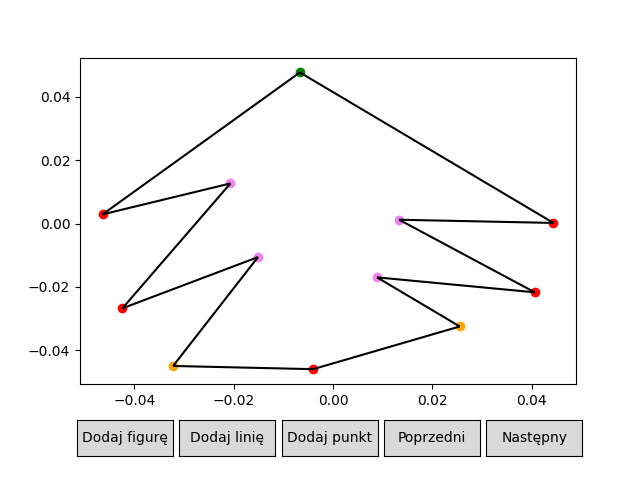

In [171]:
if Y_monotinic(points1):
    print("Jest y-monotoniczny")
else:
    print("Nie jest y-monotoniczny")

classify(points1, lines1)

## Wielokąt 2 (z wykładu, przy klasifikacji punktów)

<IPython.core.display.Javascript object>


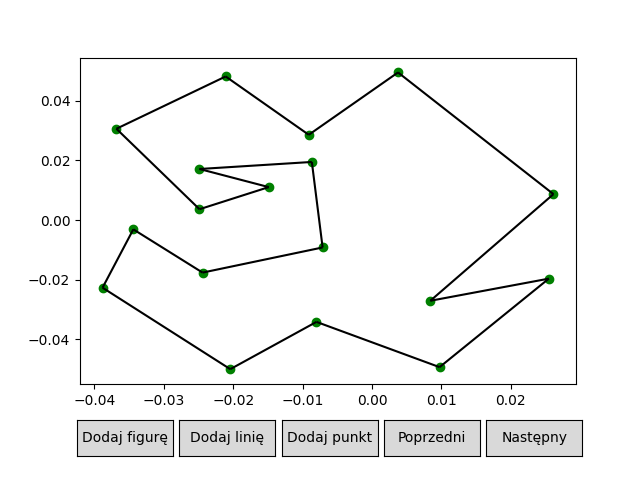

In [172]:
# wielokąt z rodzajami wierzchołków z wykładu
lines2 = [[(-0.008006049740699031, -0.03412223853316962), (0.009735885743171926, -0.04928767970964021)], 
          [(0.009735885743171926, -0.04928767970964021), (0.02548185348510741, -0.019630816964542164)],
          [(0.02548185348510741, -0.019630816964542164), (0.008405240581881607, -0.027045032650816675)],
          [(0.008405240581881607, -0.027045032650816675), (0.026147176065752578, 0.008678006564869611)], 
          [(0.026147176065752578, 0.008678006564869611), (0.0037479825173654807, 0.04945619283937944)], 
          [(0.0037479825173654807, 0.04945619283937944), (-0.009114920708440971, 0.028561584996242173)], 
          [(-0.009114920708440971, 0.028561584996242173), (-0.021090727160053876, 0.04810815362369317)], 
          [(-0.021090727160053876, 0.04810815362369317), (-0.03683669490198936, 0.030583643819771578)],
          [(-0.03683669490198936, 0.030583643819771578), (-0.024860888450376456, 0.003622859506046086)], 
          [(-0.024860888450376456, 0.003622859506046086), (-0.014881049740699037, 0.011037075192320597)], 
          [(-0.014881049740699037, 0.011037075192320597), (-0.024860888450376456, 0.017103251662908825)], 
          [(-0.024860888450376456, 0.017103251662908825), (-0.008671372321344198, 0.01946232029035981)],
          [(-0.008671372321344198, 0.01946232029035981), (-0.007118952966505485, -0.009183513042973532)], 
          [(-0.007118952966505485, -0.009183513042973532), (-0.024417340063279683, -0.017608758141012745)], 
          [(-0.024417340063279683, -0.017608758141012745), (-0.0343971787729571, -0.0031173365723852903)], 
          [(-0.0343971787729571, -0.0031173365723852903), (-0.03883266264392485, -0.022663905199836284)], 
          [(-0.03883266264392485, -0.022663905199836284), (-0.020425404579408717, -0.049961699317483343)], 
          [(-0.020425404579408717, -0.049961699317483343), (-0.008006049740699031, -0.03412223853316962)]]


points2 = lines_to_points(lines2)

scene = [Scene([PointsCollection(points2, color='green')], [LinesCollection(lines2, color='black')])]
    
plot = Plot(scene)
plot.draw()


### Klasyfikacja punktów

Nie jest y-monotoniczny


<IPython.core.display.Javascript object>


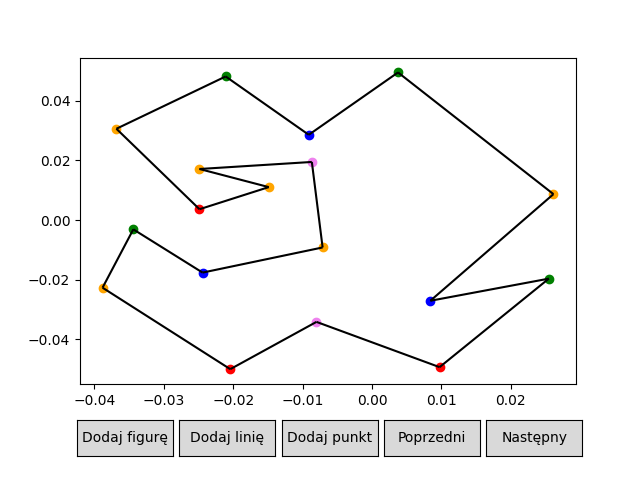

In [173]:
if Y_monotinic(points2):
    print("Jest y-monotoniczny")
else:
    print("Nie jest y-monotoniczny")

classify(points2, lines2)

## Wielokąt 3

<IPython.core.display.Javascript object>


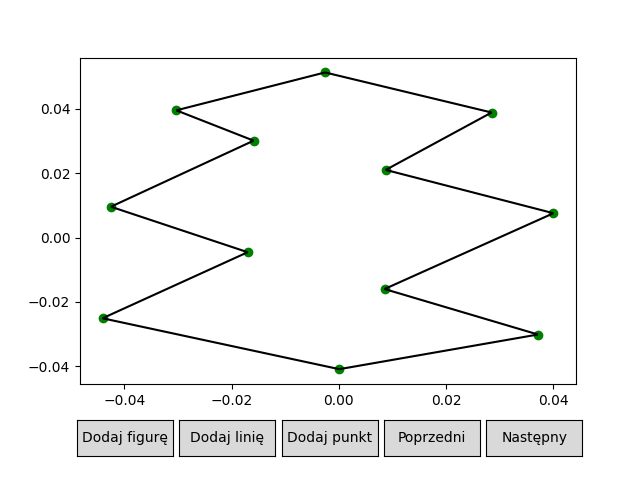

In [174]:
lines3 = [[(8.871509182836745e-05, -0.04096354372361127), (0.037125005414409024, -0.030179229998121074)],
          [(0.037125005414409024, -0.030179229998121074), (0.008516134446667087, -0.016024818233415186)], 
          [(0.008516134446667087, -0.016024818233415186), (0.04000806993053806, 0.007565868041094617)], 
          [(0.04000806993053806, 0.007565868041094617), (0.008737908640215467, 0.02104626019795737)],
          [(0.008737908640215467, 0.02104626019795737), (0.028475811866021924, 0.03890777980580051)],
          [(0.028475811866021924, 0.03890777980580051), (-0.002572575230752272, 0.051377142550898564)], 
          [(-0.002572575230752272, 0.051377142550898564), (-0.030294349424300662, 0.03958179941364365)],
          [(-0.030294349424300662, 0.03958179941364365), (-0.015879026843655504, 0.030145524903839732)], 
          [(-0.015879026843655504, 0.030145524903839732), (-0.042491930069461954, 0.009587926864624036)], 
          [(-0.042491930069461954, 0.009587926864624036), (-0.016987897811397437, -0.004566484900081852)], 
          [(-0.016987897811397437, -0.004566484900081852), (-0.04404434942430066, -0.02512408293929754)], 
          [(-0.04404434942430066, -0.02512408293929754), (8.871509182836745e-05, -0.04096354372361127)]]

points3 = lines_to_points(lines3)


scene = [Scene([PointsCollection(points3, color='green')], [LinesCollection(lines3, color='black')])]
    
plot = Plot(scene)
plot.draw()


### Klasyfikacja punktów

Jest y-monotoniczny


<IPython.core.display.Javascript object>


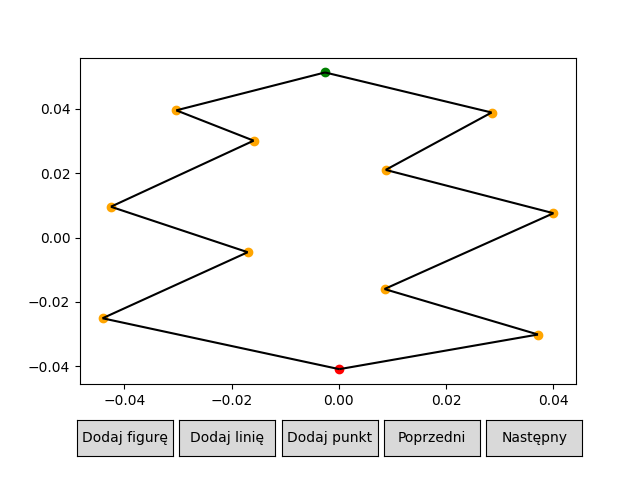

In [175]:
if Y_monotinic(points3):
    print("Jest y-monotoniczny")
else:
    print("Nie jest y-monotoniczny")

classify(points3, lines3)

### Triangulacja wielokąta

In [157]:
points3 = lines_to_points(lines3)
d,s = triangulate(points3, lines3)

plot = Plot(s)
plot.draw()

<IPython.core.display.Javascript object>

## Wielokąt 4

<IPython.core.display.Javascript object>


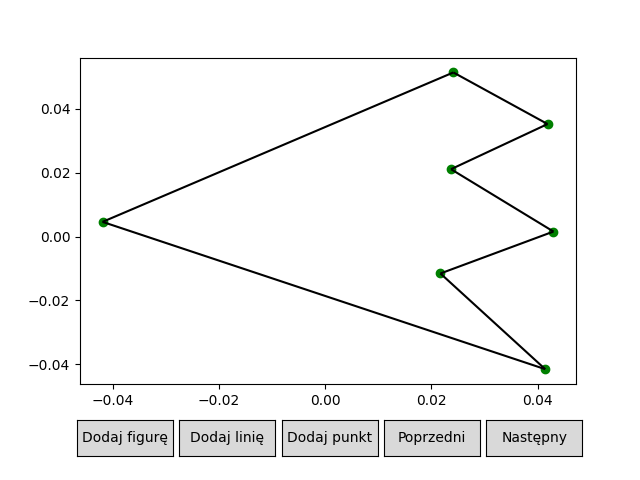

In [143]:
lines4 = [[(-0.04193750135360226, 0.004588944678213094), (0.04144959542059129, -0.041581398459041824)],
          [(0.04144959542059129, -0.041581398459041824), (0.021711692194784832, -0.011587525910022212)], 
          [(0.021711692194784832, -0.011587525910022212), (0.04300201477543, 0.0015558564429189736)],
          [(0.04300201477543, 0.0015558564429189736), (0.02370765993672032, 0.021102425070369968)],
          [(0.02370765993672032, 0.021102425070369968), (0.04189314380768806, 0.03525683683507584)], 
          [(0.04189314380768806, 0.03525683683507584), (0.02415120832381709, 0.05143330742331115)], 
          [(0.02415120832381709, 0.05143330742331115), (-0.04193750135360226, 0.004588944678213094)]]

points4 = lines_to_points(lines4)

scene = [Scene([PointsCollection(points4, color='green')], [LinesCollection(lines4, color='black')])]
    
plot = Plot(scene)
plot.draw()



### Klasyfikacja punktów

Jest y-monotoniczny


<IPython.core.display.Javascript object>


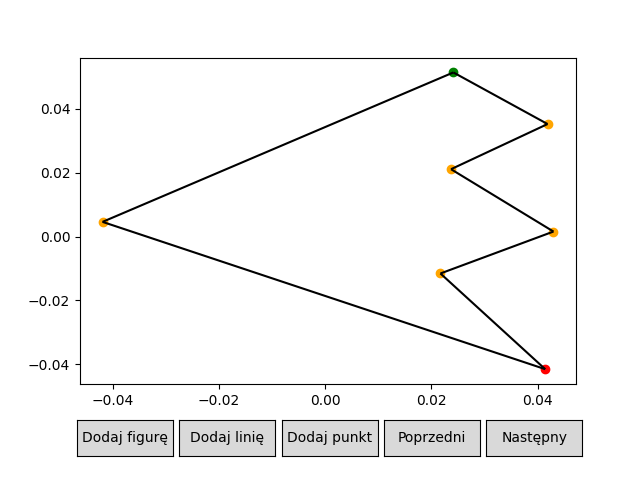

In [144]:
if Y_monotinic(points4):
    print("Jest y-monotoniczny")
else:
    print("Nie jest y-monotoniczny")

classify(points4, lines4)

### Triangulacja wielokąta

<IPython.core.display.Javascript object>


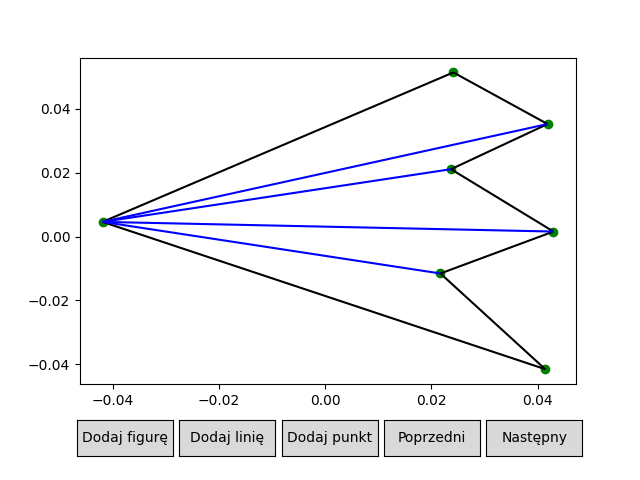

In [145]:
d,s = triangulate(points4, lines4)

plot = Plot(s)
plot.draw()


## Wielokąt 5

<IPython.core.display.Javascript object>


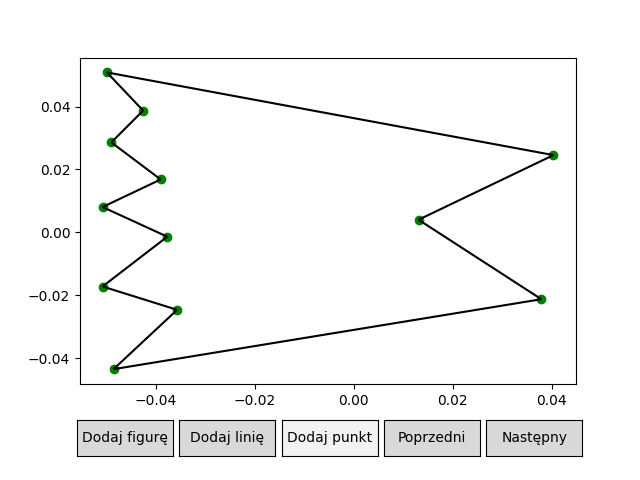

In [114]:
lines5 = [[(0.03790120832381709, -0.021270937171636833), (0.013062498646397733, 0.004004798122480821)], 
          [(0.013062498646397733, 0.004004798122480821), (0.04034072445284935, 0.024562396161696504)], 
          [(0.04034072445284935, 0.024562396161696504), (-0.0499213723213442, 0.050849160867578874)], 
          [(-0.0499213723213442, 0.050849160867578874), (-0.04260282393424743, 0.03871680792640239)], 
          [(-0.04260282393424743, 0.03871680792640239), (-0.04903427554715065, 0.028606513808755327)], 
          [(-0.04903427554715065, 0.028606513808755327), (-0.039054436837473235, 0.016811170671500425)], 
          [(-0.039054436837473235, 0.016811170671500425), (-0.05080846909553775, 0.008048915769539644)], 
          [(-0.05080846909553775, 0.008048915769539644), (-0.03772379167618291, -0.0013873587402642856)], 
          [(-0.03772379167618291, -0.0013873587402642856), (-0.05080846909553775, -0.01722681952457801)], 
          [(-0.05080846909553775, -0.01722681952457801), (-0.03572782393424743, -0.02464103521085252)], 
          [(-0.03572782393424743, -0.02464103521085252), (-0.04859072716005387, -0.043513584230460374)], 
          [(-0.04859072716005387, -0.043513584230460374), (0.03790120832381709, -0.021270937171636833)]]

points5 = lines_to_points(lines5)

scene = [Scene([PointsCollection(points5, color='green')], [LinesCollection(lines5, color='black')])]
    
plot = Plot(scene)
plot.draw()



### Klasyfikacja punktów

Jest y-monotoniczny


<IPython.core.display.Javascript object>


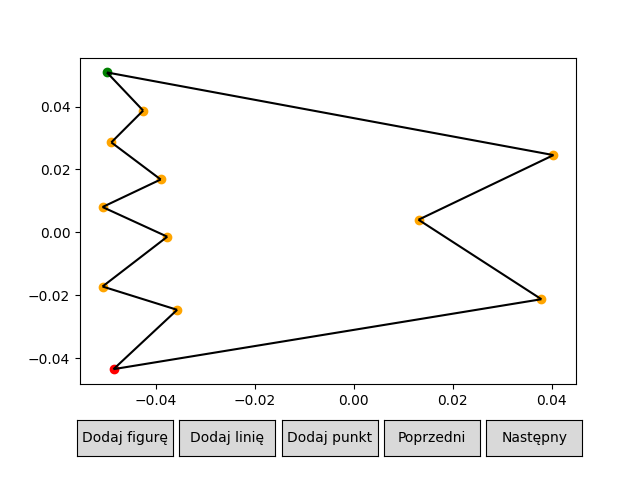

In [115]:
if Y_monotinic(points5):
    print("Jest y-monotoniczny")
else:
    print("Nie jest y-monotoniczny")

classify(points5, lines5)

### Triangulacja wielokąta

In [146]:
points5 = lines_to_points(lines5)
d,s = triangulate(points5, lines5)


plot = Plot(s)
plot.draw()

<IPython.core.display.Javascript object>